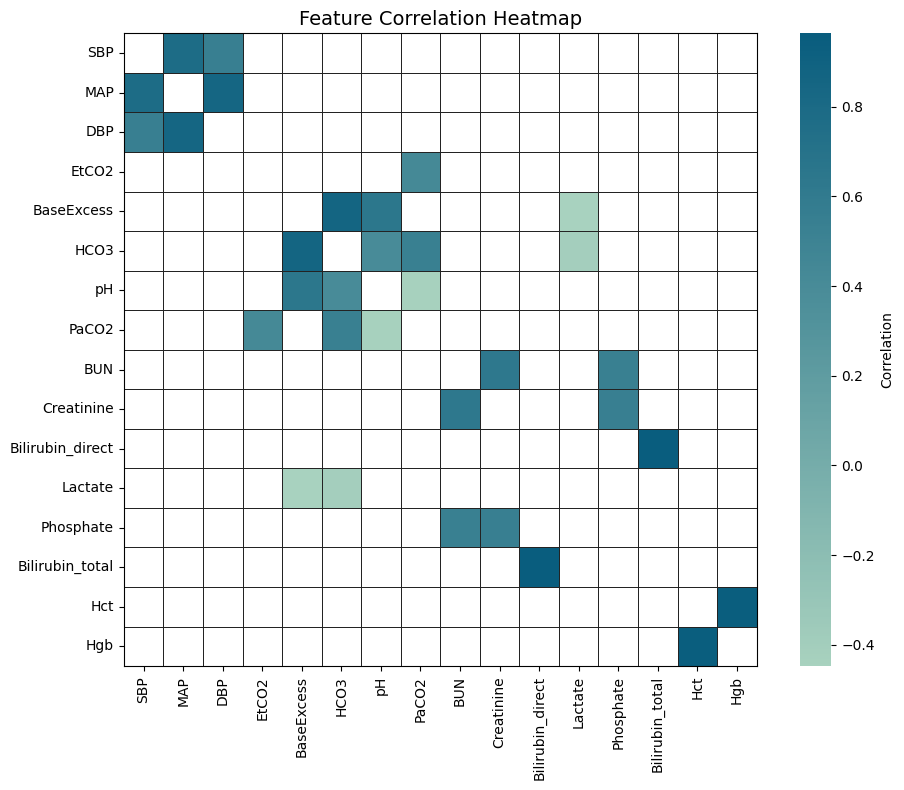

In [295]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Define paths
folder_a = "training_setA"
folder_b = "training_setB"

# Define relevant feature columns (indexes start from 0)
feature_columns = list(range(8)) + list(range(8, 34))

# Function to read all .psv files in a folder and extract relevant columns
def load_data(folder):
    data_frames = []
    for filename in os.listdir(folder):
        if filename.endswith(".psv"):
            file_path = os.path.join(folder, filename)
            df = pd.read_csv(file_path, sep='|')
            df = df.iloc[:, feature_columns]  # Select relevant columns
            data_frames.append(df)
    return pd.concat(data_frames, ignore_index=True)

# Load datasets
data_a = load_data(folder_a)
data_b = load_data(folder_b)

# Combine datasets
combined_data = pd.concat([data_a, data_b], ignore_index=True)

# Compute correlation matrix
correlation_matrix = combined_data.corr()

# Remove self-correlation (set diagonal to NaN)
np.fill_diagonal(correlation_matrix.values, np.nan)

# Set weak correlations (|corr| < 0.4) to NaN
correlation_matrix[np.abs(correlation_matrix) < 0.4] = np.nan

# Remove features that have no strong correlations (all values NaN)
filtered_corr_matrix = correlation_matrix.dropna(how="all", axis=0).dropna(how="all", axis=1)

custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_gradient", ["#e2fcd6", "#095d7e"]
)

# Plot the lower-triangle heatmap with Viridis colormap
plt.figure(figsize=(10, 8))
sns.heatmap(
    filtered_corr_matrix,
    cmap=custom_cmap,  
    center=0,  # Ensure 0 correlation is mapped to the middle color
    linewidths=0.5,
    linecolor="#232323",
    square=True,  # Ensures uniform cells, helping with grid visibility
    cbar_kws={"label": "Correlation"},
    annot=False  # Set to True for numerical values inside the heatmap
)

# Manually draw missing border lines
plt.gca().spines["top"].set_visible(True)
plt.gca().spines["right"].set_visible(True)
plt.gca().spines["bottom"].set_visible(True)
plt.gca().spines["left"].set_visible(True)

# Format labels
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.title("Feature Correlation Heatmap", fontsize=14)

# Save and Show
plt.tight_layout()
plt.savefig("triangular_correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

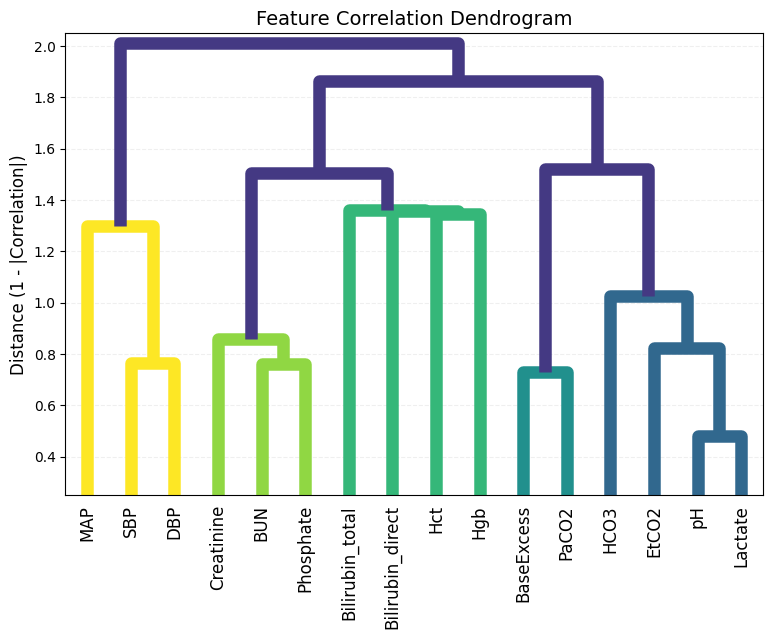

In [271]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib

# Convert NaNs to 0 for clustering
corr_for_clustering = filtered_corr_matrix.fillna(0)

# Compute hierarchical clustering
linkage_matrix = linkage(1 - np.abs(corr_for_clustering), method="ward")

# Find the linkage pair for HGB & HCT
feature_list = filtered_corr_matrix.columns.tolist()

# Create the figure
plt.figure(figsize=(9, 6))

# Generate the dendrogram (without color modifications yet)
dendro = dendrogram(
    linkage_matrix,
    labels=filtered_corr_matrix.columns,
    leaf_rotation=90,
    color_threshold=1.4,  # Adjust when colors start changing
    above_threshold_color="black",  # Top-level branches in black
)

# Apply gradient colors to branches based on their height in the dendrogram
ax = plt.gca()
cmap = matplotlib.colormaps.get_cmap("viridis").reversed()   # Updated colormap functio
for i, line in enumerate(ax.collections):
    color = cmap(i / len(ax.collections))  # Get color from gradient
    line.set_color(color)  # Apply gradient color
    line.set_linewidth(9)  # Increase branch thickness


# Formatting
plt.title("Feature Correlation Dendrogram", fontsize=14)
plt.ylabel("Distance (1 - |Correlation|)", fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.2)

# Set minimum correlation for visualization
plt.ylim(0.25, 2.05)

# Show plot
plt.show()